# Multivariate Interpolation on Scattered Data with SciPy

In this notebook, we will tackle a more common and complex problem: interpolating data that is **scattered** or unstructured. This situation arises when collecting experimental data, where sensor placement may be irregular, or in computational simulations using adaptive meshes.

Unlike structured grids, we no longer have a simple grid index. Instead, we have a list of points $(x_i, y_i)$ and corresponding values $z_i$. Our goal remains the same: to construct a continuous function $f(x, y)$ that approximates our data and allows us to estimate values anywhere within the domain.

Today, we will investigate SciPy's powerful tools for this task:
* `griddata`: A convenient, all-in-one function.
* `LinearNDInterpolator` & `NearestNDInterpolator`: Object-oriented methods based on triangulations.
* `CloughTocher2DInterpolator`: A more sophisticated, continuously differentiable ($C^1$) method.
* `RBFInterpolator`: A powerful method using Radial Basis Functions, which is excellent for creating smooth, visually pleasing surfaces.

We will use the MATLAB **peaks** function as our ground truth for comparison.

## 1. Setup and Test Data

First, we define our test function. Instead of sampling it on a regular grid, we will now generate a set of **randomly scattered points**. This will be our "known" data. We will still use a fine *regular* grid to evaluate our interpolated functions and visualize the results.

The "peaks" function will be our test function; it is a combination of several Gaussian distributions, which makes it suitable for testing interpolation methods.

The function is defined as:
$$
z(x, y) = 3(1-x)^2 e^{-x^2 - (y+1)^2} - 10\left(\frac{x}{5} - x^3 - y^5\right)e^{-x^2 - y^2} - \frac{1}{3}e^{-(x+1)^2 - y^2}
$$

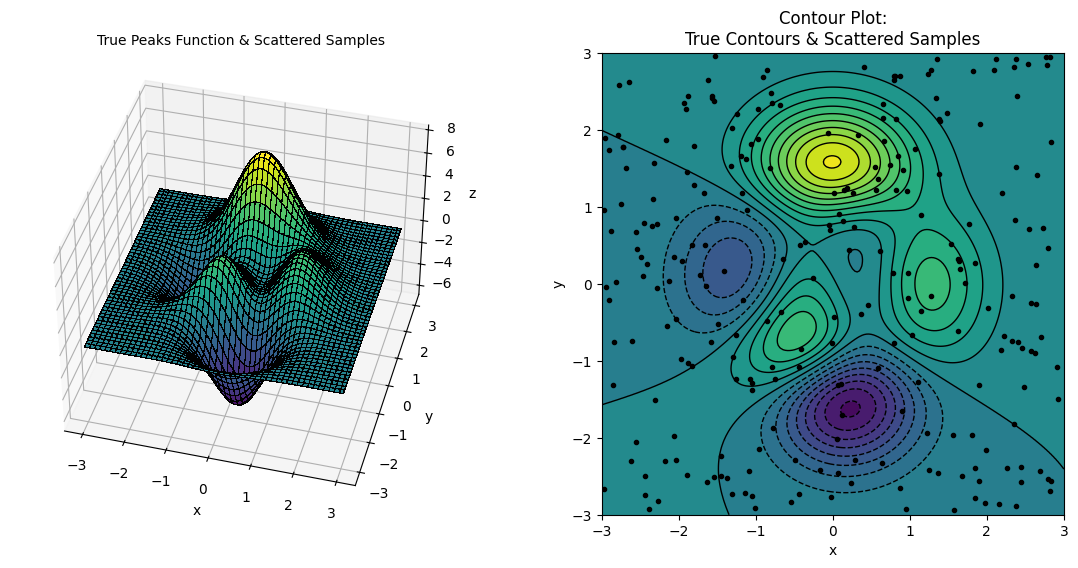

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import (griddata,
                               LinearNDInterpolator,
                               NearestNDInterpolator,
                               CloughTocher2DInterpolator,
                               RBFInterpolator)
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

# Set a seed for reproducibility of random points
np.random.seed(42)

# Define the peaks function
def peaks(x, y):
    return 3 * (1 - x)**2 * np.exp(-(x**2) - (y + 1)**2) \
           - 10 * (x/5 - x**3 - y**5)*np.exp(-x**2 - y**2) \
           - np.exp(-(x + 1)**2 - y**2)/3

# 1. Create the SCATTERED data (our "known" data)
# Generate 250 random points within the [-3, 3] range
x_scattered = 6*np.random.rand(250) - 3
y_scattered = 6*np.random.rand(250) - 3
z_scattered = peaks(x_scattered, y_scattered)
scattered_points = np.vstack((x_scattered, y_scattered)).T

# 2. Create the fine grid for interpolation and plotting the "true" surface
x_fine = np.linspace(-3, 3, 200)
y_fine = np.linspace(-3, 3, 200)
xx_fine, yy_fine = np.meshgrid(x_fine, y_fine)
z_true = peaks(xx_fine, yy_fine)

# Modified plotting functions for scattered data
def plot_3d(ax, x, y, z, title, show_samples=False):
    """
    Helper for a detailed 3D plot with scattered samples.
    """
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='black', linewidth=0.1, antialiased=False)
    #ax.contour3D(x, y, z, 20, colors='black', levels=20, linewidths=2)

    if show_samples:
        ax.scatter(x_scattered, y_scattered, z_scattered, c='black', marker='.', s=15, label='Sample Points')

    ax.set_title(title, fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=40, azim=-75)

def plot_2d_contour(ax, x, y, z, title, show_samples=True):
    """
    Helper for a 2D contour plot with scattered samples.
    """
    ax.contour(x, y, z, 20, colors='k', linewidths=1)
    ax.contourf(x, y, z, 20, cmap='viridis')
    if show_samples:
        ax.scatter(x_scattered, y_scattered, c='black', marker='.')
    ax.set_title(f'Contour Plot:\n{title}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')

# Plot the ground truth and the scattered data points
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plot_3d(ax1, xx_fine, yy_fine, z_true, "True Peaks Function & Scattered Samples")

ax2 = fig.add_subplot(1, 2, 2)
plot_2d_contour(ax2, xx_fine, yy_fine, z_true, "True Contours & Scattered Samples")
plt.show()

## 2. Triangulation-Based Interpolators

These methods work by first creating a **Delaunay triangulation** of the scattered data points. This connects the points into a mesh of non-overlapping triangles. Interpolation is then performed within these triangles.

### 2.1 `griddata` (cubic)
`griddata` is a convenient wrapper function. The `cubic` method wraps the `CloughTocher2DInterpolator` class.

### 2.2 `LinearNDInterpolator`
This object-oriented interpolator performs linear interpolation within each triangle. The resulting surface is continuous but not smooth, with visible creases along the triangle edges. This is analogous to `interpn` with `method='linear'` for structured grids.

### 2.3 `NearestNDInterpolator`
This simply returns the value of the nearest data point. The surface is discontinuous and appears as a set of flat regions (Voronoi cells).

### 2.4 `CloughTocher2DInterpolator`
This is a more sophisticated $C^1$ interpolator. It works by subdividing each triangle in the Delaunay triangulation into smaller sub-triangles and constructing a cubic polynomial that is smooth across the edges of the original triangles.

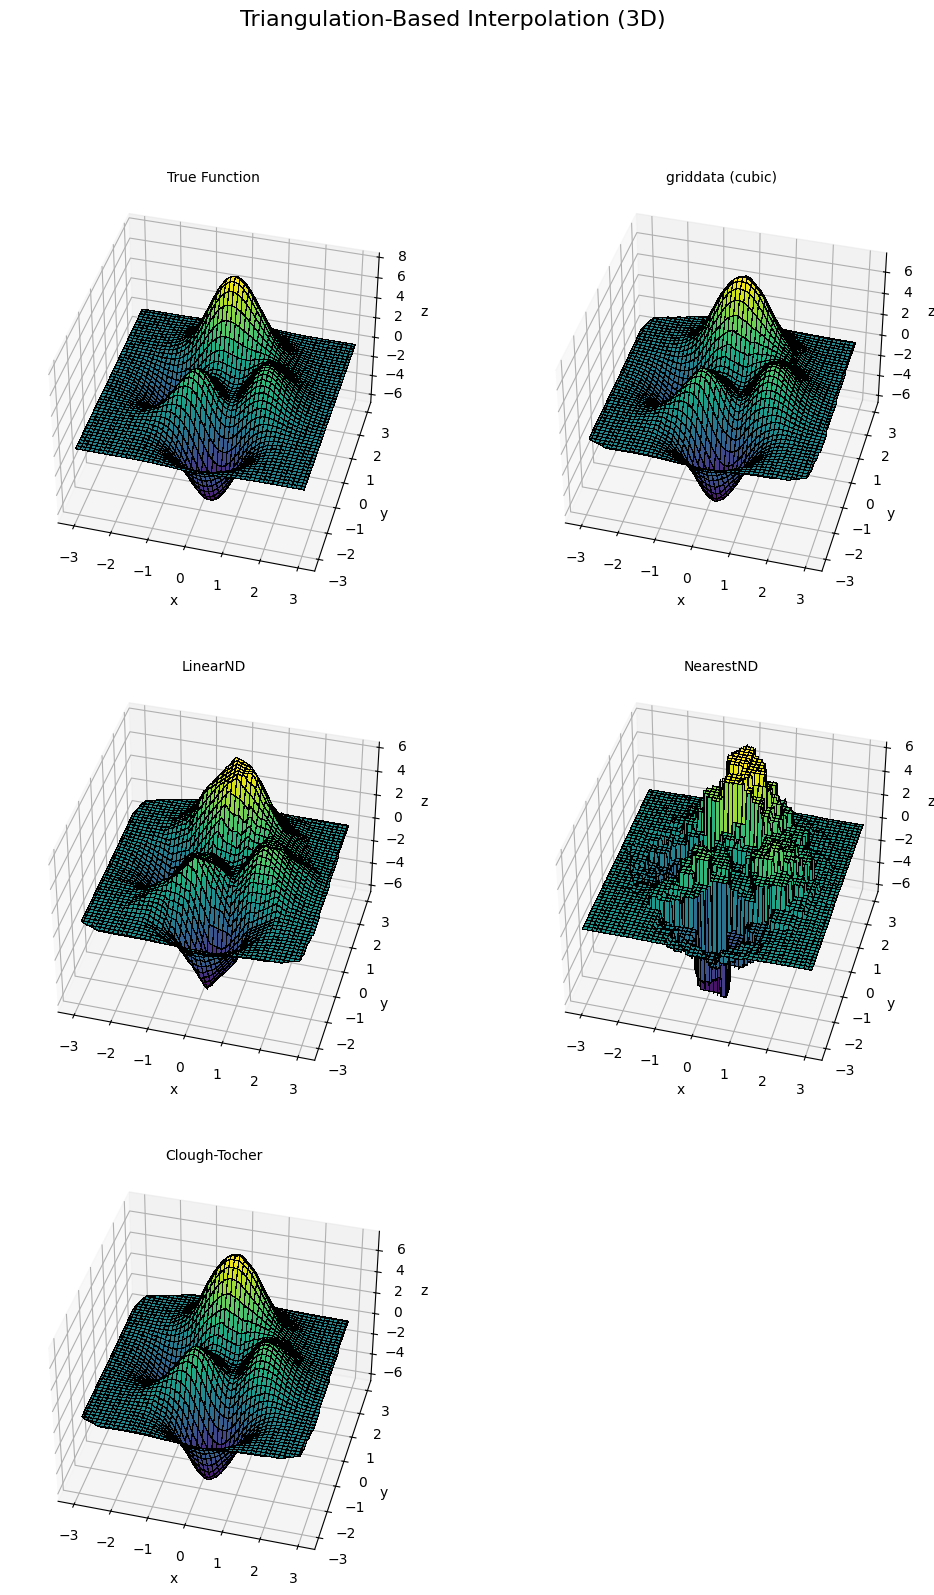

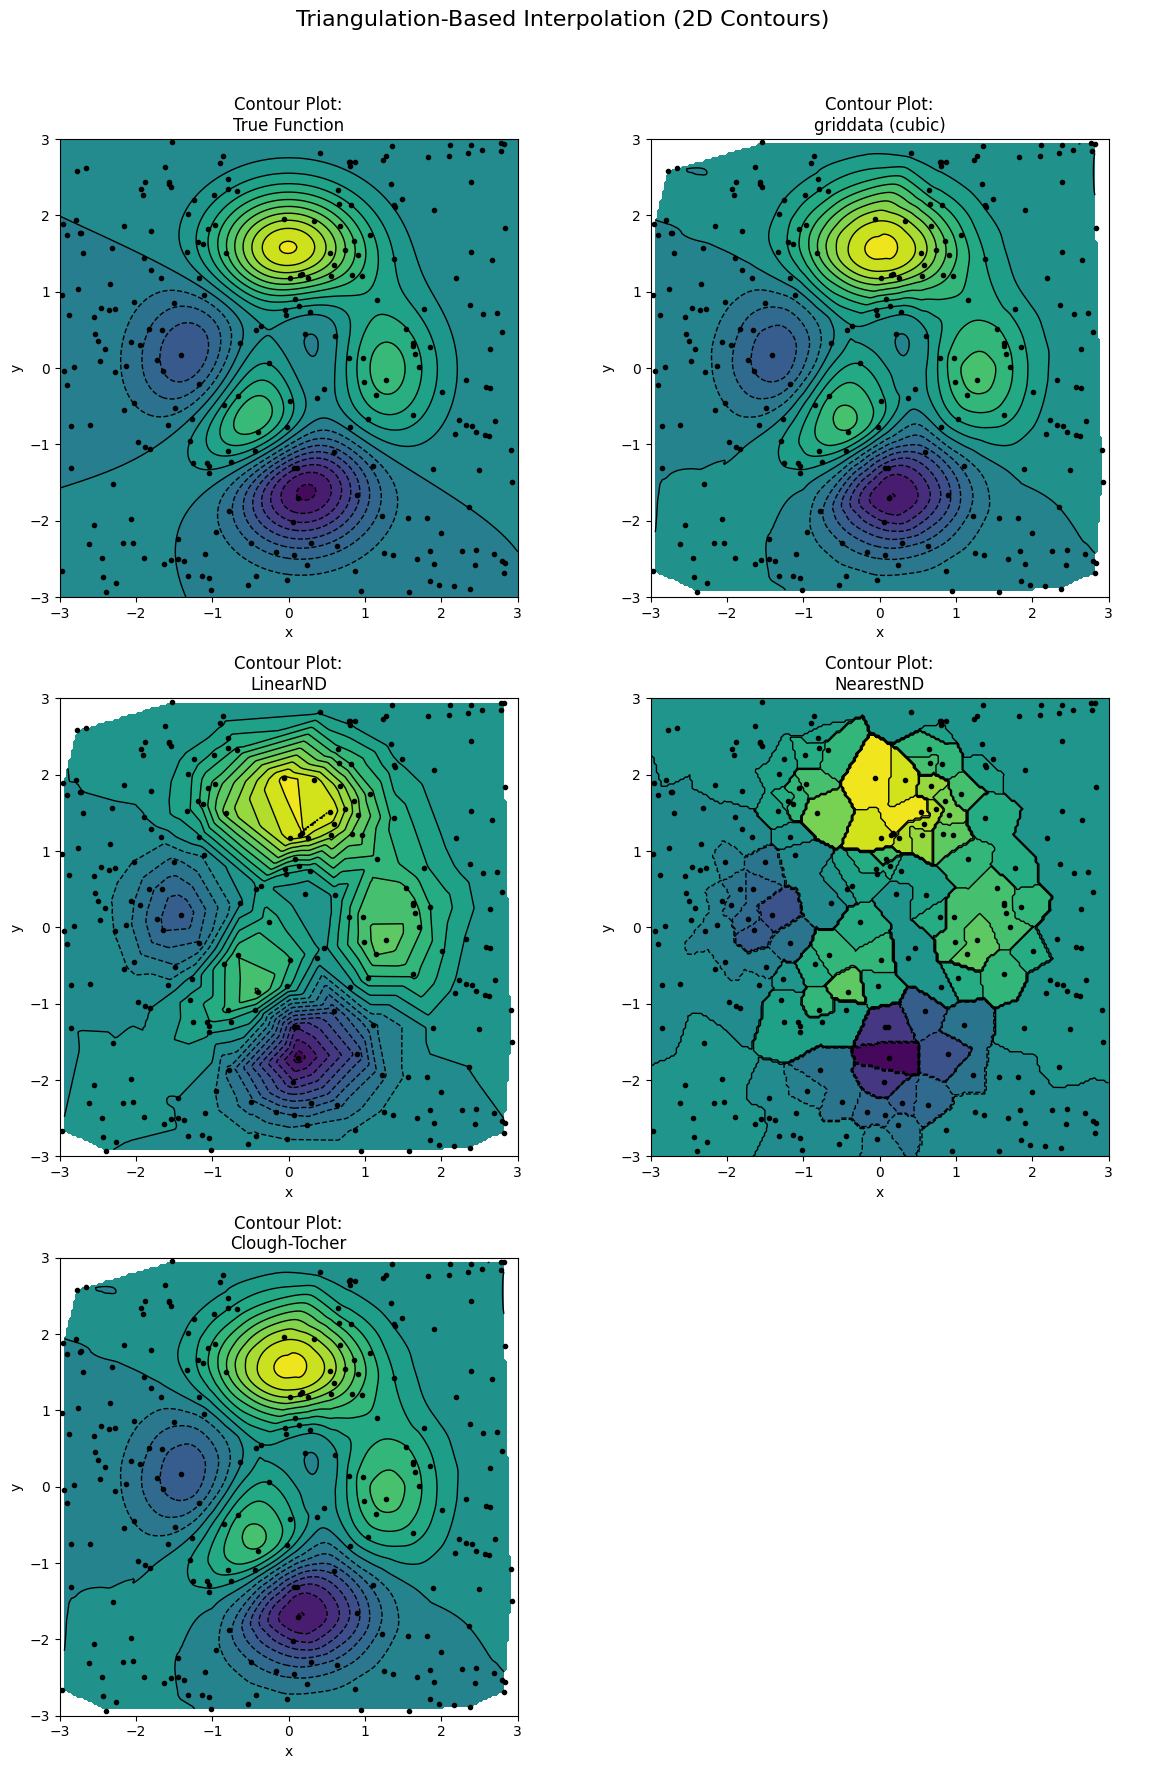

In [ ]:
# --- Store all results in a dictionary for easy plotting ---
tri_results = {}
points_to_evaluate = np.vstack((xx_fine.ravel(), yy_fine.ravel())).T

# griddata (cubic)
z_griddata_cubic = griddata(scattered_points, z_scattered, (xx_fine, yy_fine), method='cubic')
tri_results['griddata (cubic)'] = z_griddata_cubic

# LinearNDInterpolator
lin_interp = LinearNDInterpolator(scattered_points, z_scattered)
z_linear_nd = lin_interp(xx_fine, yy_fine)
tri_results['LinearND'] = z_linear_nd

# NearestNDInterpolator
near_interp = NearestNDInterpolator(scattered_points, z_scattered)
z_nearest_nd = near_interp(xx_fine, yy_fine)
tri_results['NearestND'] = z_nearest_nd

# CloughTocher2DInterpolator
ct_interp = CloughTocher2DInterpolator(scattered_points, z_scattered)
z_ct = ct_interp(xx_fine, yy_fine)
tri_results['Clough-Tocher'] = z_ct

# --- Plotting the Triangulation-Based Methods with True Function Comparison ---
# Create a 2x3 grid to hold the true function + 4 methods + 1 empty plot
fig_3d, axes_3d = plt.subplots(3, 2, figsize=(12, 18), subplot_kw={'projection': '3d'})
fig_3d.suptitle('Triangulation-Based Interpolation (3D)', fontsize=16)
axes_flat_3d = axes_3d.flatten()

fig_2d, axes_2d = plt.subplots(3, 2, figsize=(12, 18))
fig_2d.suptitle('Triangulation-Based Interpolation (2D Contours)', fontsize=16)
axes_flat_2d = axes_2d.flatten()

# Plot the True Function in the first subplot
plot_3d(        axes_flat_3d[0], xx_fine, yy_fine, z_true, "True Function")
plot_2d_contour(axes_flat_2d[0], xx_fine, yy_fine, z_true, "True Function")

# Plot the interpolation results
for i, (title, z_data) in enumerate(tri_results.items()):
    plot_3d(axes_flat_3d[i + 1], xx_fine, yy_fine, z_data, title)
    plot_2d_contour(axes_flat_2d[i + 1], xx_fine, yy_fine, z_data, title)

# Turn off the last, unused subplot
axes_flat_3d[-1].axis('off')
axes_flat_2d[-1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Notice how the `LinearND` result shows sharp triangular facets, and `NearestND` shows distinct zones of constant value. `Clough-Tocher` provides a much smoother result that begins to approximate the true function quite well.

## 3. `RBFInterpolator`: Radial Basis Functions

RBF interpolation is a powerful, modern technique that doesn't rely on triangulation. It models the interpolated surface as a weighted sum of radially symmetric basis functions centered at each data point.

The general form of the interpolant is:
$$
f(x) = \sum_{i=1}^{N} w_i \phi(\|x - x_i\|) + p(x)
$$

where $\phi(r)$ is a radial basis function, $\|x - x_i\|$ is the Euclidean distance from the evaluation point $x$ to a data point $x_i$, $w_i$ are weights, and $p(x)$ is a low-degree polynomial term to ensure stability.

SciPy's `RBFInterpolator` provides several kernels ($\phi$); some of them require a shape parameter, $\epsilon$, to be specified:

| Kernel                 | Formula $\phi(r)$                          | Characteristics                                         |
| ---------------------- | ------------------------------------------ | ------------------------------------------------------- |
| **linear** | $r$                                        | $C^0$ continuous, conical shapes                        |
| **thin_plate_spline** | $r^2 \log(r)$                              | Very smooth, classic choice for elasticity problems     |
| **cubic** | $r^3$                                      | $C^2$ smooth, similar to thin plate                     |
| **quintic** | $-r^5$                                      | Even smoother ($C^4$), good for high-precision needs    |
| **multiquadric** | $-\sqrt{1 + (\epsilon r)^2}$                | Infinitely smooth, very popular and robust              |
| **inverse_multiquadric** | $1 / \sqrt{1 + (\epsilon r)^2}$              | Localized influence, good for dense data                |
| **inverse_quadratic** | $1 / (1 + (\epsilon r)^2)$                  | Similar to inverse multiquadric                         |
| **gaussian** | $e^{-(\epsilon r)^2}$                       | Infinitely smooth, localized, like a "blur" effect      |

The $\epsilon$ is a shape parameter that scales the influence of the kernel. We will calculate a heuristic value for  ϵ  based on the average distance between our sample points.

Calculated epsilon heuristic: 0.3085


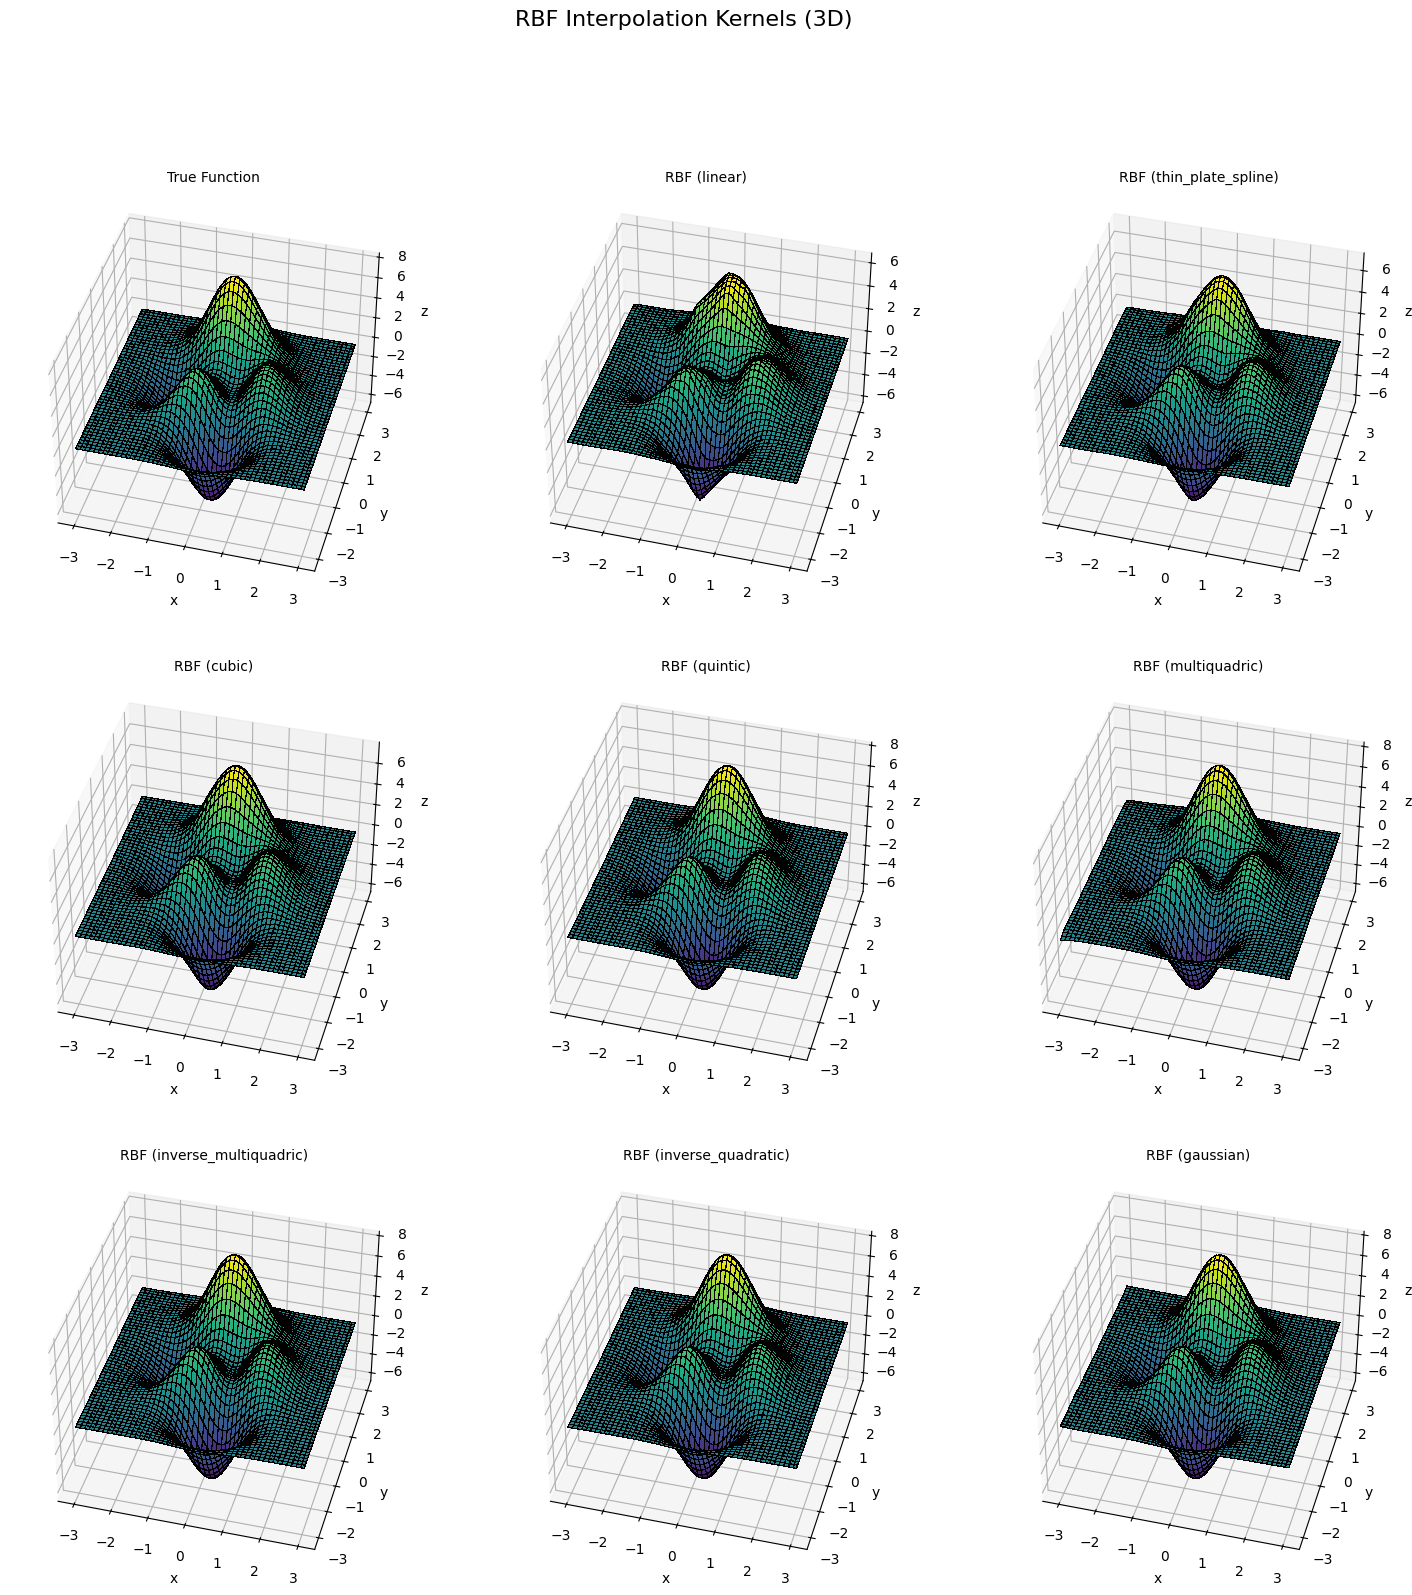

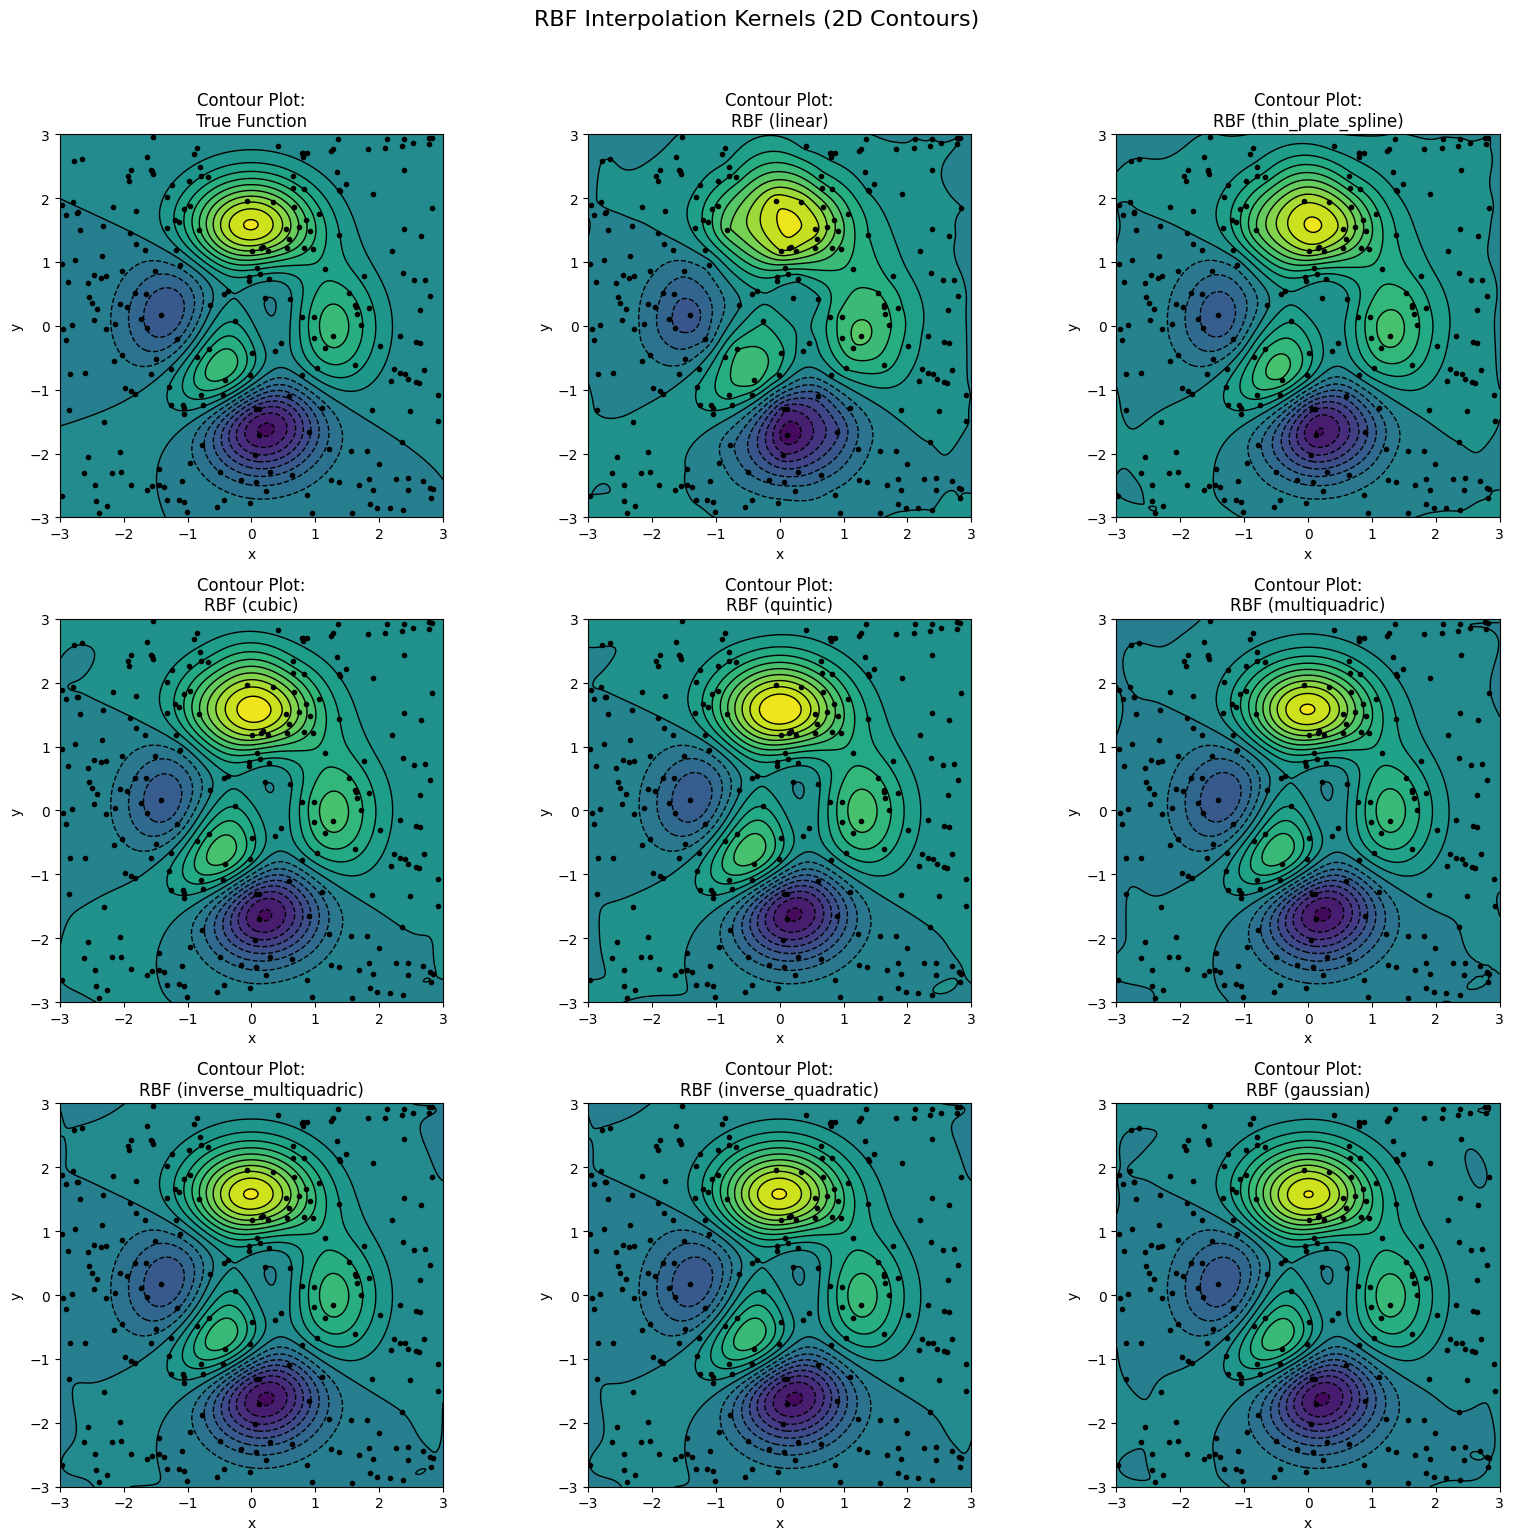

In [ ]:
rbf_results = {}
kernels = ['linear', 'thin_plate_spline', 'cubic', 'quintic',
           'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian']
needs_epsilon = {'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian'}

# Heuristic for epsilon
pairwise_dists = pdist(scattered_points)
avg_dist = np.mean(pairwise_dists)
epsilon_val = 1/avg_dist
print(f"Calculated epsilon heuristic: {epsilon_val:.4f}")

# Run RBF interpolators
for kernel in kernels:
    if kernel in needs_epsilon:
        if kernel == 'gaussian':
            rbf_interp = RBFInterpolator(scattered_points, z_scattered, kernel=kernel, epsilon=0.5*avg_dist)
        else:
            rbf_interp = RBFInterpolator(scattered_points, z_scattered, kernel=kernel, epsilon=epsilon_val)
    else:
        rbf_interp = RBFInterpolator(scattered_points, z_scattered, kernel=kernel)

    z_rbf = rbf_interp(points_to_evaluate).reshape(xx_fine.shape)
    rbf_results[f'RBF ({kernel})'] = z_rbf

# --- Plotting the RBF Methods with True Function Comparison ---
# Create a 3x3 grid for the true function + 8 kernels
fig_3d_rbf, axes_3d_rbf = plt.subplots(3, 3, figsize=(18, 18), subplot_kw={'projection': '3d'})
fig_3d_rbf.suptitle('RBF Interpolation Kernels (3D)', fontsize=16)
axes_flat_3d_rbf = axes_3d_rbf.flatten()

fig_2d_rbf, axes_2d_rbf = plt.subplots(3, 3, figsize=(16, 16))
fig_2d_rbf.suptitle('RBF Interpolation Kernels (2D Contours)', fontsize=16)
axes_flat_2d_rbf = axes_2d_rbf.flatten()

# Plot the True Function in the first subplot
plot_3d(        axes_flat_3d_rbf[0], xx_fine, yy_fine, z_true, "True Function")
plot_2d_contour(axes_flat_2d_rbf[0], xx_fine, yy_fine, z_true, "True Function")

# Plot the RBF results
for i, (title, z_data) in enumerate(rbf_results.items()):
    plot_3d(        axes_flat_3d_rbf[i + 1], xx_fine, yy_fine, z_data, title)
    plot_2d_contour(axes_flat_2d_rbf[i + 1], xx_fine, yy_fine, z_data, title)

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()

## 4. Conclusion & Recommendations


Interpolating scattered data is more complex than structured data, and the choice of method has a significant impact on the result.

* **For quick and simple interpolation**, `LinearNDInterpolator` is fast and robust, though the resulting surface is not smooth. `NearestNDInterpolator` is even faster but should only be used when a discontinuous approximation is acceptable.

* **For smooth, high-quality surfaces**, `CloughTocher2DInterpolator` is an excellent choice among the triangulation-based methods, providing guaranteed $C^1$ smoothness; however, it still struggles to capture the full curvature of the peaks compared to the true function.

* **For the most flexible and often highest-quality results**, `RBFInterpolator` is the state-of-the-art.
    * The **scale-invariant kernels** (`thin_plate_spline`, `cubic`, etc.) are the easiest to use as they don't require tuning `epsilon`. `thin_plate_spline` is a fantastic general-purpose choice.
    * The **scale-dependent kernels** (`multiquadric`, `gaussian`, etc.) are very powerful but require a thoughtful choice of `epsilon`. The heuristic we used is a good starting point, but for mission-critical applications, you may need to tune this parameter to get the best results.
    * The `thin_plate_spline` kernel is a fantastic general-purpose choice, producing smooth and natural-looking surfaces.
    * The `multiquadric` kernel is also a very strong contender.
    * The `gaussian` and `inverse_` kernels have more localized influence, which can be beneficial if you want to prevent distant points from affecting the interpolation, but they can sometimes produce flat spots if the data is sparse. These kernels show more localized behavior, which can be useful but may not always capture the global trends as effectively, as seen in the comparison.

**Final Engineering Advice:** Always start by visualizing your scattered data. For most applications requiring a smooth physical representation (e.g., stress analysis, temperature maps), **`RBFInterpolator` with a `thin_plate_spline` or `multiquadric` kernel** is the recommended starting point. Start with the **`thin_plate_spline`** kernel for its excellent performance and ease of use (no `epsilon` tuning required). If the results are not satisfactory, experiment with other kernels, always comparing back to any known ground truth or validation data you may have. If you encounter issues or have very specific data characteristics, experimenting with other RBF kernels or falling back to the robust `CloughTocher2DInterpolator` is a sound strategy.

# Homework

Implement crossvalidation for finding a good value of $\epsilon$.